In [1]:
#!pip install shap

In [16]:
import shap

In [17]:

import logging

import sys

In [18]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import root_mean_squared_error
from collections import defaultdict

import optuna
import logging
import sys

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import time

#np.random.seed(42)

SOURCE_PATH = 'data/merged.csv'
def prepare_past_ID_s(data_train):
    data_train['shop_item'] = [tuple([shop, item]) for shop, item in zip(data_train['shop_id'], data_train['item_id'])]
    #34 block contains A LOT more shop_item than others
    shop_item_pairs_in_dbn = data_train.groupby('date_block_num')['shop_item'].apply(np.unique)
    data_train = data_train.drop(['shop_item'], axis=1)
    
    shop_item_pairs_WITH_PREV_in_dbn = shop_item_pairs_in_dbn.copy()
    
    print(np.array(shop_item_pairs_WITH_PREV_in_dbn.index))
    arr = np.array(shop_item_pairs_WITH_PREV_in_dbn.index)
    
    for block in arr[arr>=0]:
        if block == 0:
            continue

        
        arr = np.append(shop_item_pairs_WITH_PREV_in_dbn[block -1],
                                                            shop_item_pairs_in_dbn[block-1])
        
        
        shop_item_pairs_WITH_PREV_in_dbn[block] = np.unique(np.append(shop_item_pairs_WITH_PREV_in_dbn[block -1],
                                                            shop_item_pairs_in_dbn[block-1]))
        print(len(shop_item_pairs_WITH_PREV_in_dbn[block]))

    return shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn

def prepare_past_ID_s_CARTESIAN(data_train):
    data_train['shop_item'] = [tuple([shop, item]) for shop, item in zip(data_train['shop_id'], data_train['item_id'])]
    #34 block contains A LOT more shop_item than others
    shop_item_pairs_in_dbn = data_train.groupby('date_block_num')['shop_item'].apply(np.unique)
    data_train = data_train.drop(['shop_item'], axis=1)
    
    shop_item_pairs_WITH_PREV_in_dbn = np.array([None] * len(shop_item_pairs_in_dbn))
    
    #print(np.array(shop_item_pairs_WITH_PREV_in_dbn.index))
    

    cartesians = []
    for dbn in shop_item_pairs_in_dbn.index:
        val = shop_item_pairs_in_dbn[dbn]

        shops = np.unique(list(zip(*val))[0])
        items = np.unique(list(zip(*val))[1])
    
        cartesian_product = np.random.permutation (np.array(np.meshgrid(shops, items)).T.reshape(-1, 2))
        #print(cartesian_product)
        cartesians.append(cartesian_product)
        
    
    shop_item_pairs_WITH_PREV_in_dbn[0] = cartesians[0]
    
    for block in shop_item_pairs_in_dbn.index:
        if block == 0:
            continue
        arr = np.append(shop_item_pairs_WITH_PREV_in_dbn[block - 1],
                             cartesians[block - 1], axis=0)#shop_item_pairs_WITH_PREV_in_dbn doesnt contain 34 month
        
        shop_item_pairs_WITH_PREV_in_dbn[block] = np.unique(arr, axis=0)
        print(len(shop_item_pairs_WITH_PREV_in_dbn[block]))
    return shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn

def make_X_lag_format(data, dbn):
    """
    transform X to lag format
    columns with dbn in names become lag_0, dbn-1 - lag_1 etc.
    """
    
    lag_cols = defaultdict()
    for col in data.columns:
        splitted = col.split('$')
        if len(splitted) == 1:
            continue
        
        lag_cols[col] = splitted[0] + '_lag;' + str(dbn - int(splitted[1]))

    #print(lag_cols)
    data = data.rename(columns=dict(lag_cols))
    #print(data.columns)
    return data

def prepare_train(data, valid ):
    """
    returns one batch of merged data with required IDs from valid
    """
    #print(data)
    valid_shop_item = valid
    valid_shop_item = list(zip(*valid_shop_item))
    df = pd.DataFrame({'item_id':valid_shop_item[1],'shop_id':valid_shop_item[0]} )
    data = df.merge(data, on=['shop_id','item_id'], how='inner').fillna(0)

    return data


def prepare_val(data, valid ):
    """
    returns one batch of merged data with required IDs from valid
    """
    
    df = pd.DataFrame({'item_id':valid[:,1],'shop_id':valid[:,0]} )
    data = df.merge(data, on=['shop_id','item_id'], how='inner').fillna(0)
    #print('prepare_val, data:',len(data))
    return data

def prepare_data_train_boosting(data, valid, dbn):
    """
    
    """
    train = prepare_train (data, valid)
    lag_cols = []
    for col in data.columns:
        
        splitted = col.split('$')
        if len(splitted) == 1:
                lag_cols.append(col)
                continue
        #if 'shop_item_cnt' not in col:
        #    continue
            
        for db in range(0,dbn-1):
            
            if db == int(splitted[1]):
                #print(col)
                lag_cols.append(col)

    #print(lag_cols)
    X = train[lag_cols]
    Y = train[f'value_shop_id_item_id${dbn-1}']
    
    return X, Y


def prepare_data_validation_boosting(data, valid, dbn):
    """
    
    """
    test = prepare_val (data, valid)
    
    lag_cols = []
    for col in test.columns:
        
            
        splitted = col.split('$')
        if len(splitted) == 1:
                lag_cols.append(col)
                continue
        #if 'shop_item_cnt' not in col:
        #    continue
        for db in range(1,dbn):
            
            if db == int(splitted[1]):
                #print(db, int(''.join(re.findall(r'\d+', col))))
                lag_cols.append(col)

    X = test[lag_cols]
    Y = test[f'value_shop_id_item_id${dbn}']#value_shop_id_item_id
    
    return X, Y

def select_columns_for_reading(path, dbn):
   
    columns = pd.read_csv(path, nrows=0).columns.tolist()

    cols = []
    for col in columns:
        l = col.split('$')
        if len(l) == 1:
            cols.append(col)
            continue

        name = l[0]
        num=int(l[1])
        dbn_diff = dbn - num
        
        if 'value_shop_id_item_id' in col and np.isclose(dbn_diff,0):#target
            cols.append(col)

        if dbn_diff<=0:
            continue


        if 'ema' in name and dbn_diff <= 3:
            cols.append(col)
            continue
        elif 'value_shop_id_item_id' in name and (dbn_diff <= 6 or dbn_diff == 12):
            cols.append(col)
            continue
        elif 'value_price' in name and dbn_diff <= 1:
            cols.append(col)
            continue
        elif 'value' in name and dbn_diff <= 3:
            cols.append(col)
            continue
        elif 'diff' in name and dbn_diff == 1:
            cols.append(col)
            continue
        elif 'change' in name and dbn_diff <= 2:
            cols.append(col)
            continue


    return cols

def create_batch_train(batch_size, dbn, shop_item_pairs_WITH_PREV_in_dbn, batch_size_to_read):
    """
    
    """
    
    train = np.random.permutation (shop_item_pairs_WITH_PREV_in_dbn[dbn])#-1?????????

    #chunk_num =  len(train)// batch_size if len(train)%batch_size==0  else   len(train) // batch_size + 1#MAY BE NEED TO CORRECT
    chunk_num =  len(train)// batch_size if len(train)>=batch_size else 1#MAY BE NEED TO CORRECT
    columns = select_columns_for_reading(SOURCE_PATH, dbn-1)#-1?????
    for idx in range(chunk_num):#split shop_item_pairs_WITH_PREV_in_dbn into chuncks
        t1 = time.time()
        l_x=[]
        l_y=[]
        merged = pd.read_csv(SOURCE_PATH, chunksize=batch_size_to_read, skipinitialspace=True, usecols=columns)
        l_sum = 0
        for chunck in merged:#split merged into chuncks
            
            l =  prepare_data_train_boosting(chunck,train[idx*batch_size:(idx+1)*batch_size], dbn) 
            #print(len(l[0]))
            l_sum += len(l[0])
            l_x.append( l[0] )
            l_y. append(l[1])
        
        if len(l_x) == 0:
            return [None, None]
        print('create_batch_train, 203:',l_sum)
        l_x = pd.concat(l_x)
        l_y = pd.concat(l_y)

        t2 = time.time()
        print('batch creation time [create_batch_train, 212],',t2-t1)
        return [l_x, l_y]#, test

def create_batch_val(batch_size, dbn, shop_item_pairs_in_dbn, batch_size_to_read):
    """
    
    """
    
    val = shop_item_pairs_in_dbn[dbn]
    
    shops = np.unique(list(zip(*val))[0])
    items = np.unique(list(zip(*val))[1])

    cartesian_product = np.random.permutation (np.array(np.meshgrid(shops, items)).T.reshape(-1, 2))
    
    chunk_num =  len(cartesian_product)// batch_size if len(cartesian_product)%batch_size==0  else   len(cartesian_product) // batch_size + 1#MAY BE NEED TO CORRECT

    columns = select_columns_for_reading(SOURCE_PATH, dbn)


    for idx in range(chunk_num):
        merged = pd.read_csv(SOURCE_PATH, chunksize=batch_size_to_read, skipinitialspace=True, usecols=columns)
        l_x=[]
        l_y=[]
        l_sum=0
        cartesian = cartesian_product[idx*batch_size:(idx+1)*batch_size]

        for chunck in merged:
            #print('chunck',len(chunck))
            #print('cartesian_product',len(cartesian))
            
            l =  prepare_data_validation_boosting(chunck,cartesian, dbn) 
            l_sum+=len(l[0])
            l_x.append( l[0] )
            l_y. append( l[1] )

        if len(l_x) == 0:
            return [None, None]
        print('create_batch_val,243:',l_sum)
        l_x = pd.concat(l_x)
        l_y = pd.concat(l_y)

        #print('prepare_batch_val, l_x:',l_x)
        return [l_x,l_y]#, test


def select_columns(X_train, dbn):#WHEN LINEAR MODELS, X_train = append_some_columns(X_train,dbn) - to comment
    X_train = append_some_columns(X_train,dbn)
    cols=[]
    for col in X_train.columns:
        l = col.split(';')
        if len(l) == 1:
            cols.append(col)
            continue
        name = l[0]
        num = int(l[1])
        if 'ema' in name:
           if num <= 3:
                cols.append(col)
                continue
        if 'value_shop_id_item_id' in name:
            if num <=6 or num == 12:
                cols.append(col)
                continue
        if 'value_shop_id_lag' in name:
            continue

        if 'value_price' in name:
            if num <= 1:
                cols.append(col)
                continue
            
        if 'value' in name:
            if num <=3:
                cols.append(col)
                continue
            
        if 'diff' in name:
            if num == 1:
                cols.append(col)
                continue
            continue
            
        if 'change' in name:

            if num <= 2:
                cols.append(col)
                continue

            continue
        
    return X_train[cols]

def append_some_columns(X_train, dbn):
    X_train['date_block_num'] = dbn
    X_train['month'] = dbn%12
    return X_train

def train_model(model, batch_size, val_month, shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read,epochs,callback):
    
    first=True
    columns_order=None
    
    Y_true_l = []
    preds_l = []
    for epoch in range(epochs):
        
        X_train,Y_train  = create_batch_train(batch_size, val_month,shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read)
        t1_batch = time.time()
        Y_train = np.clip(Y_train,0,20)
        X_train = make_X_lag_format(X_train, val_month-1)
        columns_order=X_train.columns
        model=model.fit(X_train, Y_train)
            
        y_train_pred = model.predict(X_train)  
        
        Y_true_l.append(Y_train)
        preds_l.append(y_train_pred)
        t2_batch = time.time()
        print(f'train on batch {c} time,',t2_batch-t1_batch)
        c+=1
        
    train_rmse = root_mean_squared_error(pd.concat(Y_true_l), np.concat(preds_l))
    print('train_rmse, ',train_rmse)
    return model, columns_order




In [20]:


import xgboost as xgb
import lightgbm as lgb

In [24]:
def validate_ML(batch_size,val_monthes, shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read):
    """
    Function for validating model
    
    """
    
    val_errors = []
    
    val_preds=[]
    
    first=True
    shaps=[]
    for val_month in val_monthes:
        
        

        #model = xgb.XGBRegressor(eta=0.005535083103345165, max_leaves=672,nthread=8,device='gpu', enable_categorical=True,n_estimators=900)
        
        
        
        
        model = LGBMRegressor(verbose=-1,n_jobs=8, num_leaves=32, n_estimators = 900, learning_rate=0.006879070737977554)     
        X_val_to_ret = None
        print(type(model))
        explainer=None
        if type(model) == LGBMRegressor:
            X_val, Y_val = create_batch_val(batch_size, val_month, shop_item_pairs_in_dbn, batch_size_to_read)#but then cartesian product used
            Y_val = np.clip(Y_val,0,20)
            X_val = make_X_lag_format(X_val, val_month)

            X_train,Y_train  = create_batch_train(batch_size, val_month,shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read)
            Y_train = np.clip(Y_train,0,20)
            X_train = make_X_lag_format(X_train, val_month-1)
            
            columns_order = X_train.columns
            X_val=X_val[columns_order]


            X_val = X_val.drop('item_id', axis=1)
            X_val['shop_id'] = X_val['shop_id'].astype('category')
            X_val['item_category_id'] = X_val['item_category_id'].astype('category')
            X_val['city'] = X_val['city'].astype('category')
            X_val['super_category'] = X_val['super_category'].astype('category')

            X_train = X_train.drop('item_id', axis=1)
            X_train['shop_id'] = X_train['shop_id'].astype('category')
            X_train['item_category_id'] = X_train['item_category_id'].astype('category')
            X_train['city'] = X_train['city'].astype('category')
            X_train['super_category'] = X_train['super_category'].astype('category')

          
            model=model.fit(X_train, Y_train)

            print('shap calculation started...')
            explainer = shap.TreeExplainer(model)
            shap_values = explainer(X_val)
            X_val_to_ret=X_val
            

        else:
            X_val, Y_val = create_batch_val(batch_size, val_month, shop_item_pairs_in_dbn, batch_size_to_read)#but then cartesian product used
            Y_val = np.clip(Y_val,0,20)
            X_val = make_X_lag_format(X_val, val_month)

            X_train,Y_train  = create_batch_train(batch_size, val_month,shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read)
            Y_train = np.clip(Y_train,0,20)
            X_train = make_X_lag_format(X_train, val_month-1)
            
            columns_order = X_train.columns
            X_val=X_val[columns_order]
            model=model.fit(X_train, Y_train)
            
            model=model.fit(X_train, Y_train)

            print('shap calculation started...')
            explainer = shap.TreeExplainer(model)
            shap_values = explainer(X_val)
            X_val_to_ret=X_val
        first=False
    
        

    return explainer,shap_values,X_val_to_ret

In [22]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
test = pd.read_csv('../data_cleaned/test.csv')
test['date_block_num'] = 34
data_train = pd.concat([data_train,test ], ignore_index=True).drop('ID', axis=1).fillna(0)


shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn = prepare_past_ID_s_CARTESIAN(data_train)




batch_size=70000000
batch_size_to_read=200000000
epochs=1


364950
428871
466086
494493
532909
566259
587979
609623
627192
664844
686985
719696
730116
746129
775024
799403
814628
828506
851457
871899
890066
928598
952398
976804
987057
997953
1013772
1025692
1035736
1046582
1055558
1067461
1080188
1110590


In [23]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
test = pd.read_csv('../data_cleaned/test.csv')
test['date_block_num'] = 34
data_train = pd.concat([data_train,test ], ignore_index=True).drop('ID', axis=1).fillna(0)


shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn = prepare_past_ID_s_CARTESIAN(data_train)

364950
428871
466086
494493
532909
566259
587979
609623
627192
664844
686985
719696
730116
746129
775024
799403
814628
828506
851457
871899
890066
928598
952398
976804
987057
997953
1013772
1025692
1035736
1046582
1055558
1067461
1080188
1110590


In [25]:





start_val_month=[33]

batch_size=70000000
batch_size_to_read=200000000

is_create_submission=False
epochs=1

explainer, shaps, X_display = validate_ML(
                    batch_size=batch_size,
                    val_monthes=start_val_month, 
                    shop_item_pairs_in_dbn=shop_item_pairs_in_dbn,
                    shop_item_pairs_WITH_PREV_in_dbn=shop_item_pairs_WITH_PREV_in_dbn,
                    batch_size_to_read=batch_size_to_read
)
print(shaps)

<class 'lightgbm.sklearn.LGBMRegressor'>
create_batch_val,243: 238084
create_batch_train, 203: 1080188
batch creation time [create_batch_train, 212], 55.31254863739014
shap calculation started...
.values =
array([[ 9.16511858e-04, -4.52719714e-04, -6.70744816e-04, ...,
         5.61936451e-06, -8.86938768e-03,  2.96040438e-05],
       [ 9.29978986e-03, -4.26223775e-04, -3.68821162e-04, ...,
        -2.15168997e-05,  2.33431797e-03,  2.96282253e-05],
       [-2.56067295e-03, -5.08655079e-04, -5.04510265e-04, ...,
        -1.64838921e-05, -3.85475453e-03, -4.51941446e-05],
       ...,
       [-1.23923207e-02, -1.01908055e-03, -5.64442939e-04, ...,
         1.07379063e-06,  5.74886015e-03,  3.04204985e-05],
       [-1.98020362e-02, -9.57139605e-04, -9.09397089e-04, ...,
        -4.76987479e-05,  3.70870531e-03,  3.00624752e-05],
       [-2.72445128e-03,  2.64103226e-03, -5.14078998e-04, ...,
         1.04314611e-03, -3.13876912e-02,  2.47798978e-05]])

.base_values =
array([0.05349889, 0.

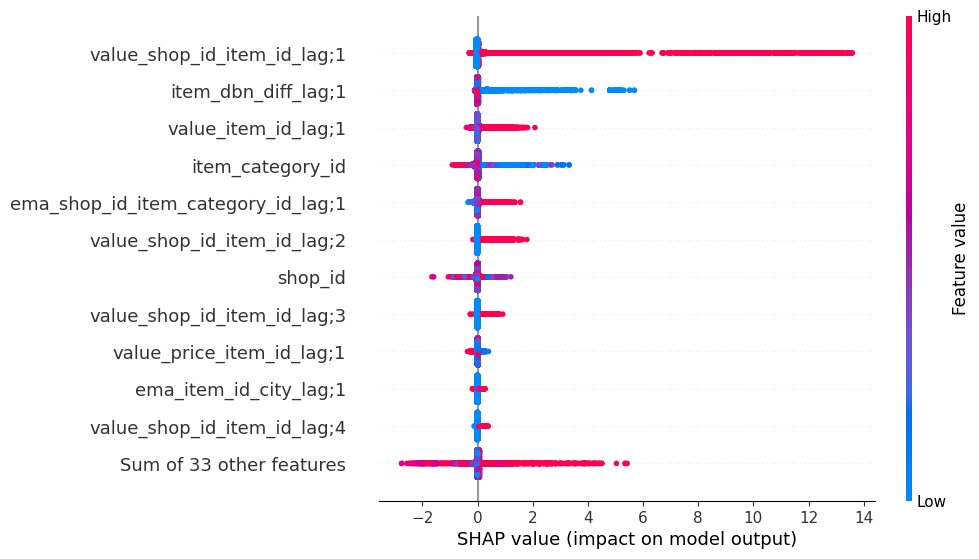

In [27]:
shap.plots.beeswarm(shaps, max_display=12)

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value, shaps.values[0, :], X_display.iloc[0, :])